## Sustained News Coverage - impact on prices?

**QUESTION**: Does sustained news coverage over an extended period have a greater impact on assets price compared to short lived spikes in volume of news stories? How does the Sentiment affect the price? 

**ANSWER**: To explore the above, we can measure the volume of news stories for a topic over a period of time and contrast it with any price movement of the related asset.

To demonstrate this I am going to:
* Fetch historical News stories from Refinitiv News sources (including Reuters) for Crude Oil
* Fetch Sentiment scores for Crude Oil
* Fetch historical Crude Oil Price data for the same time period
* Chart the Volume of stories for Crude Oil
* Overlay the chart with the Crude oil price
* Add the Sentiment scores to the chart


**A few key Crude Oil related Topic Codes**

|  RCS Code | News200 Code | Topic                                | Description                                                                                                                                                       |
|-----------|--------------|--------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| U:45      | CRU          | Crude Oil                            | Exploration, extraction, transport, processing, trading / broking, demand for and use of crude oil and gas condensate\. Organisations associated with crude oil\. |
| U:9U      | AFRCRU       | Africa Crudes                        | African crude oil streams                                                                                                                                         |
| U:8J      | AMCRU        | Americas Crudes                      | Americas crude oil streams                                                                                                                                        |
| U:9B      | ASCRU        | Asia Crudes                          | Asian crude oil streams                                                                                                                                           |
| U:9C      | AUSCRU       | Australasia Crudes                   | Australasian crude oil streams                                                                                                                                    |
| U:8T      | CANCRU       | Canada Crudes                        | Canadian crude oil streams                                                                                                                                        |
| U:9T      | EMACRU       | Europe / Middle East / Africa Crudes | Europe / Middle East / Africa crude oil streams                                                                                                                   |


The **RCS** topic code is the newer strategic system and the **News2000** code is the legacy system.  
For all new developments we recommend customers use RCS code (Refinitiv Classification Schema)

News2000 codes & RSC codes are a one-to-one mappings ~99% of the time.


### Realtime Streaming and Archive Files

Depending on your use case, you can access our News Stories and Sentiment scoring data as 
* Live Streaming Feed
* Archived Bulk File versions

I will be using Bulk Files transferred into a database

### The Code

In [1]:
import pymysql
import configparser as cp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import Formatter
import numpy as np
%matplotlib inline
import refinitiv.data as rd
from refinitiv.data.content import historical_pricing
from refinitiv.data.content.historical_pricing import Intervals
import configparser as cp
from datetime import datetime, date


config = cp.ConfigParser()
config.read("exconfig.cfg")
DATABASE='newsanalyticsdb'
datafile="crudeoil.xlsx"
myConn = ""
writeToXl = True    # Used to dump data to excel file after sourcing data from DB
loadFromXl = False    # Load data from Excel file rather than DB
plt.rcParams["figure.figsize"] = (41,12)
plt.rcParams["figure.facecolor"] = '0.25'
plt.rcParams["axes.labelsize"] = '20'
plt.rcParams["font.size"] = '20.0'
plt.rcParams["axes.labelcolor"] = 'y'
plt.rcParams["text.color"] = 'c'
plt.rcParams["legend.facecolor"]='0.25'

#### Connect to cloud server for Historical Pricing Data

In [2]:
if not loadFromXl:
    session=rd.session.platform.Definition(
    app_key=config['session']['app_key'], 
        grant=rd.session.platform.GrantPassword(
            username=config['session']['user'], 
            password=config['session']['password']
        )
    ).get_session()
    session.open()
    rd.session.set_default(session)

#### Connect to Database containing imported News Archive

In [3]:
if not loadFromXl:
    try:
        myConn = pymysql.connect(
          host="localhost",
          user=config['mysql']['user'],
          passwd=config['mysql']['password'],
          database=DATABASE
        )
    except pymysql.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with your user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)      
    else:
        print("Connected to "+ DATABASE)   
else:
    print("Loading data from "+ datafile)   
        
if writeToXl:
    writer = pd.ExcelWriter(datafile, engine='xlsxwriter')
    

Connected to newsanalyticsdb


Note that I have added the option to load the data form an Excel file rather than the MySql database. I did this primarily to speed up my testing - as the MySql queries can be somewhat time consuming.

This also means that if  you don't have a Refintiv News Analytics licence (and therefore  unable to populate a database), you can still run this notebook by setting the *loadFromXl* parameter to True and ensuring the *crudeoil.xlsx* is in the working folder.

### Helper Functions
Main code to fetch news volume data from DB based on Topic Code (or read from file!)

In [4]:
def fetch_topic(code):
    if loadFromXl:
        df = pd.read_excel(datafile, sheet_name=code)
        df['Date'] = df['Date'].dt.date
    else:
        query = ("SELECT feedDate AS Date, COUNT(*) as " + code + 
                    " FROM news "
                    "WHERE subjects "
                    "LIKE '%N2:" + code + "%' " 
                    "AND WEEKDAY(feedDate)<5 "
                    "GROUP BY feedDate "
                    "ORDER BY feedDate")
        SQL_Query = pd.read_sql_query(query, myConn)
        df = pd.DataFrame(SQL_Query)
        if writeToXl:
            df.to_excel(writer, sheet_name=code,index=False)
    return df

Main code to fetch Negative and Positive Sentiment scores from DB based on Topic Code (or read from file!)

In [5]:
def fetch_sentiment(code):
    if loadFromXl:
        df = pd.read_excel(datafile, sheet_name=code+'_SENTS')
        df['Date'] = df['Date'].dt.date
    else:
        query = ("SELECT SUM(scores.sentimentNegative) AS Negative, "
                        "SUM(scores.sentimentPositive) AS Positive, "
                        "news.feedDate AS Date "
                        "FROM news, scores "
                        "WHERE news.id = scores.id AND "
                        "news.subjects LIKE '%N2:" + code + "%' "
                        "AND WEEKDAY(feedDate)<5 "
                        "GROUP BY feedDate "
                        "ORDER BY feedDate")
        SQL_Query = pd.read_sql_query(query, myConn)
        df = pd.DataFrame(SQL_Query)
        if writeToXl:
            df.to_excel(writer, sheet_name=code+'_SENTS',index=False)
    return df   

Fetch Historical Price Data for Crude oil

In [6]:
def fetch_historical_data(sdate,edate):    
    if loadFromXl:
        df_mid_price = pd.read_excel(datafile, sheet_name='MID_PRICE')
        df_mid_price['Date'] = df_mid_price['Date'].dt.date
    else:
        start_date = datetime(sdate.year,sdate.month,sdate.day)
        end_date = datetime(edate.year,edate.month,edate.day)
        mid = historical_pricing.summaries.Definition(
            universe = 'CLc1', 
            interval = Intervals.DAILY,
            fields=['MID_PRICE'],
            start=start_date,
            end=end_date
            ).get_data()
        df_mid = mid.data.df
        df_mid['MID_PRICE'] = df_mid['MID_PRICE'].astype(float)
        df_mid.index.name='Date'
        df_mid_price = df_mid.reset_index()
        df_mid_price['Date'] = df_mid_price['Date'].apply(lambda x: x.date())
        if writeToXl:
            df_mid_price.to_excel(writer, sheet_name='MID_PRICE',index=False)
    return df_mid_price

#### Chart Plot code
Plot single chart

In [7]:
def plot_data(df,title,threshold=True):
    ax = df.plot(x = 'Date', kind='line', color = ['orange','green'], 
                 title = title, linewidth = '2',
                 xlabel = 'Date', ylabel = 'Volume')
    ax.set_facecolor('0.25')
    ax.tick_params(axis='both', colors='w', labelsize=20)
    if threshold:
        plt.axhline(y=110, color='w',linestyle=':')

Plot multiple lines

In [8]:
def plot_compare(df1,df2, title):
    df = pd.merge(df1, df2, on='Date', how='outer', sort=True)
    ax = df.plot(x='Date', kind='line', title = title ,  linewidth = '3',
                 xlabel = 'Date',ylabel = 'Volume',
                 color = ['orange','green', 'blue', 'red'])
    ax.set_facecolor('0.25')
    ax.tick_params(axis='both', colors='w', labelsize=20)
    cols = list(df.columns)
    cols.pop(0)
    max_y = df[cols].max().max()
    min_y = df[cols].min().min()
    ax.set_ylim([min_y,max_y])
    plt.axhline(y=110, color='w',linestyle=':')
    return df

In [9]:
def plot_topic(code,title):
    df = fetch_topic(code)
    plot_data(df,title)
    return df

#### Plot Volume of all Crude Oil related stories

Crude Oil - Topic Code **CRU**

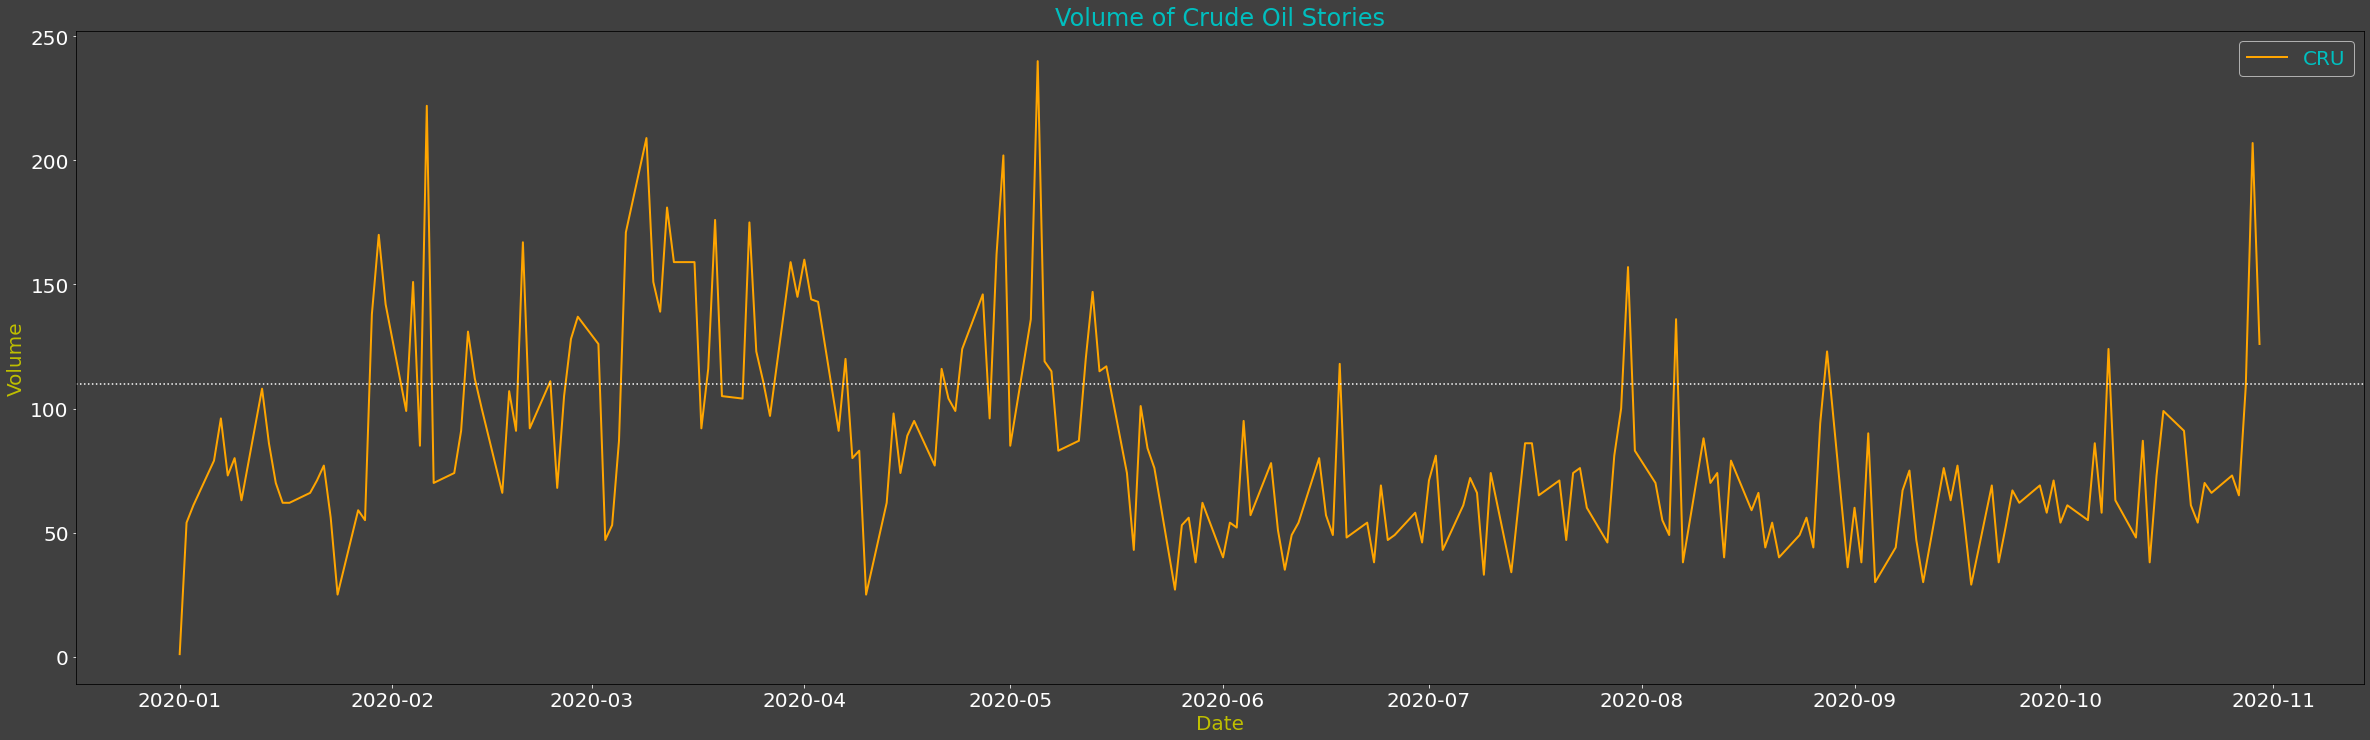

In [10]:
df_cru_stories = plot_topic('CRU','Volume of Crude Oil Stories')

Notice sustained high volume above 100 - from February / March to May and a big spike at the end of October
<br>  

Get Crude Oil Historical Prices for the same date range

In [11]:
df_mid_price = fetch_historical_data(df_cru_stories.iloc[0]['Date'],
                      df_cru_stories.iloc[-1]['Date'])

Fetch Sentiment Scores for Crude Oil

In [12]:
df_sentiments = fetch_sentiment('CRU')

Save data to file / close DB connection

In [13]:
if writeToXl:
    writer.save()    
if not loadFromXl:
    myConn.close()

#### Compare Price changes with Story Volume + Sentiment Scores

Start with Historical Prices   

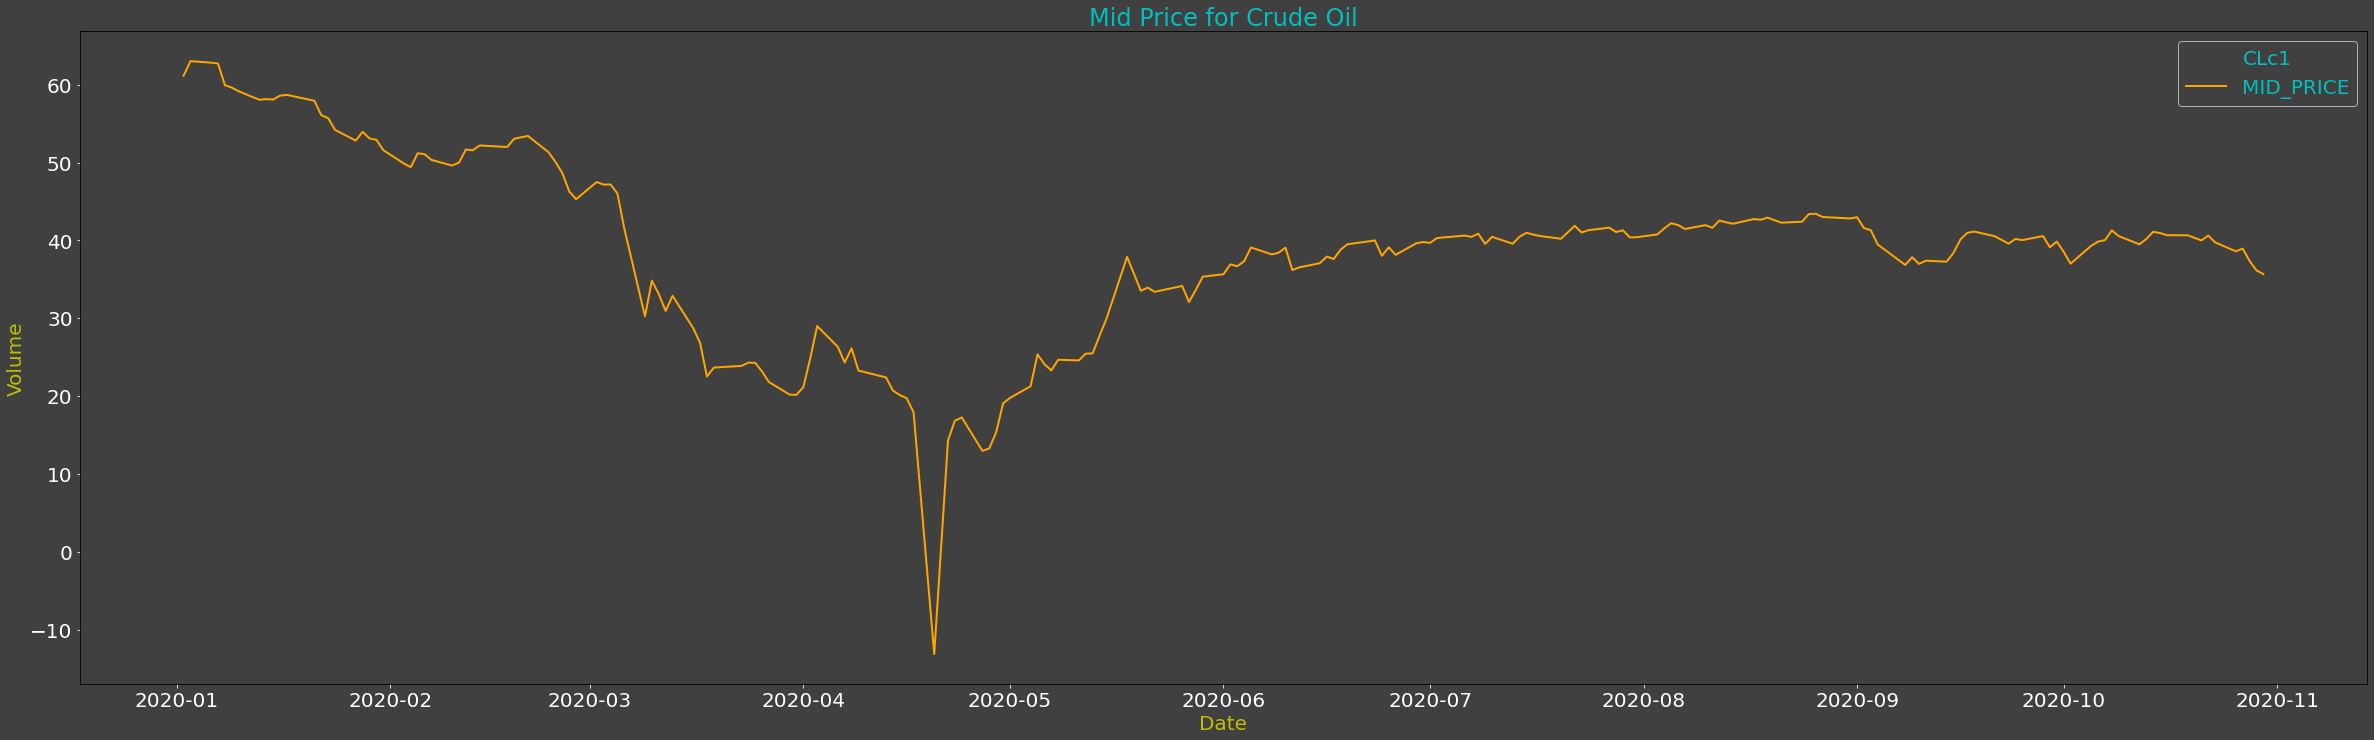

In [14]:
plot_data(df_mid_price,'Mid Price for Crude Oil',False)

<br>  

Adjust the scale for the price values  
Overlay onto Volume of Stories

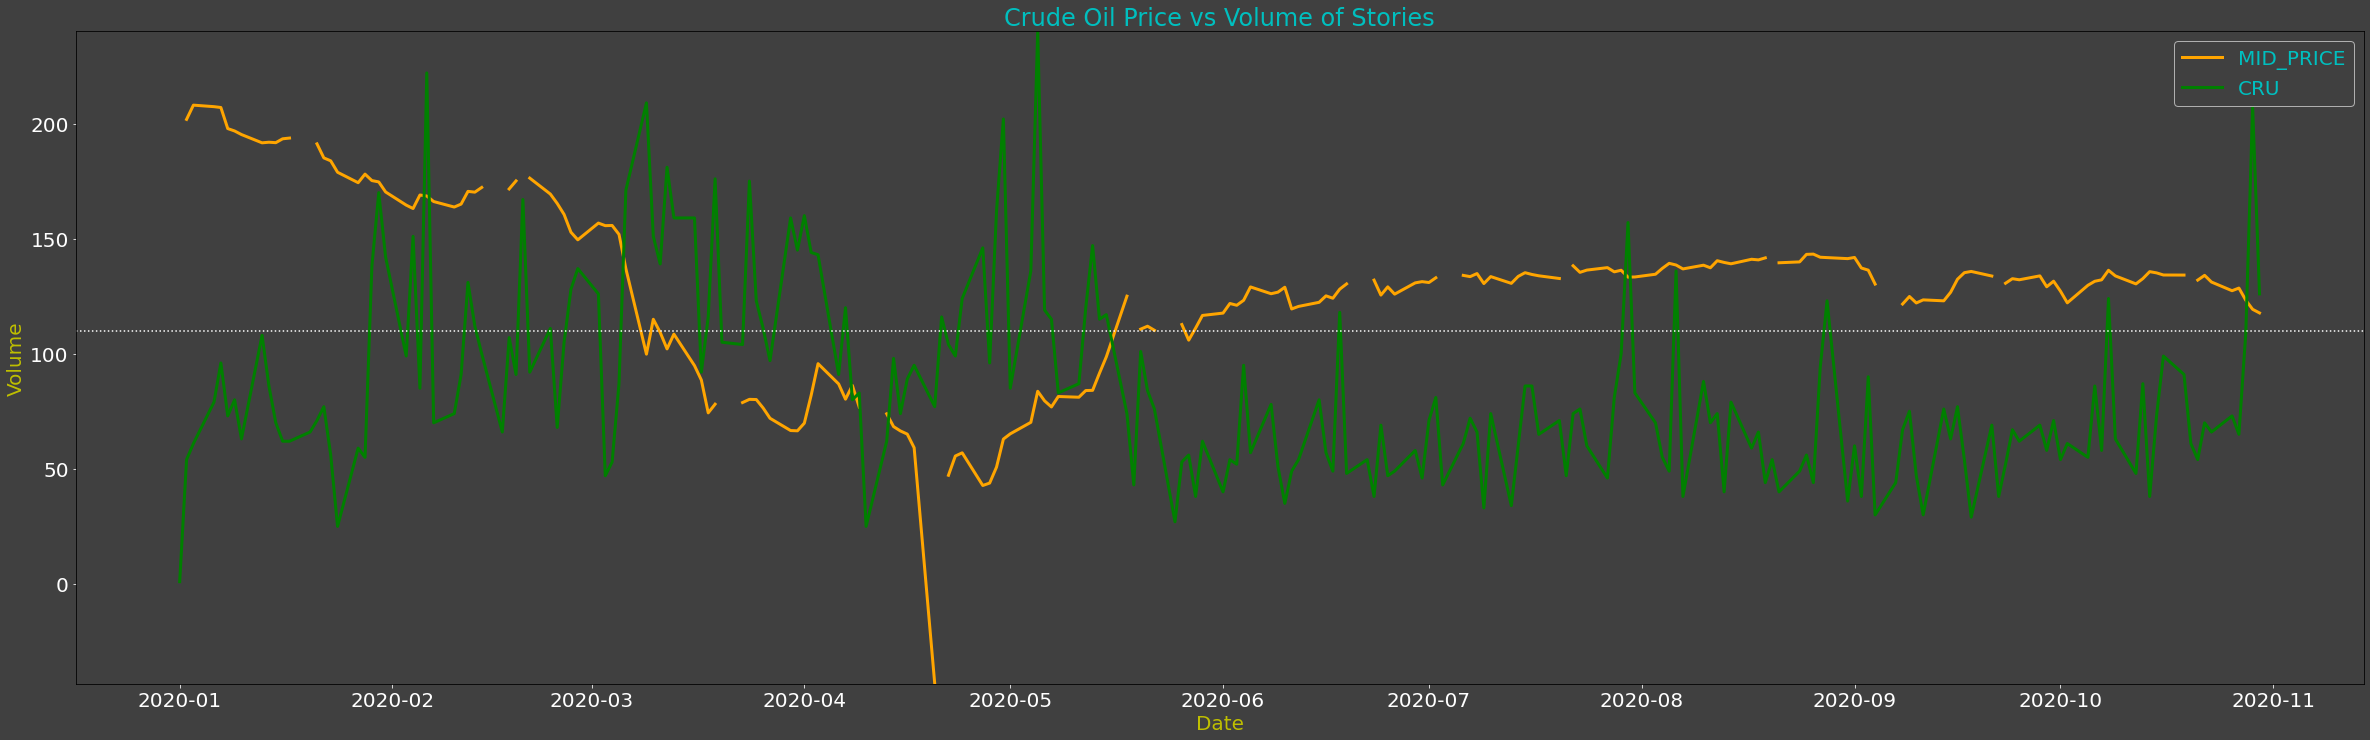

In [15]:
df_mid_price['MID_PRICE'] = df_mid_price['MID_PRICE'].apply(lambda x: x*3.3)
df_mid_vs_cru = plot_compare(df_mid_price, df_cru_stories, 'Crude Oil Price vs Volume of Stories')

You can see from the above graph that, when we have an extended period of news coverage for Crude Oil, it seems to affect the price of related assets to a greater degree - compared to when we have a short lived spike.

This can be taken a step further by looking at the News Sentiment scores and relevance scores to further refine the results of any such analysis - e.g. does Negative Sentiment result in downward price movement and vice versa?

In [16]:
df_sentiments

,Negative,Positive,Date
0,0.353226,0.427188,2020-01-01
1,44.247074,50.527212,2020-01-02
2,60.165072,36.839954,2020-01-03
3,77.849675,49.714727,2020-01-06
4,53.477457,76.877750,2020-01-07
...,...,...,...
213,71.632277,48.595189,2020-10-26
214,80.348620,54.174443,2020-10-27
215,84.039917,81.120032,2020-10-28
216,124.038385,87.024676,2020-10-29


#### Does Sentiment affect price - Impact of Negative vs Positive?
Overlay Price over Sentiment Scores

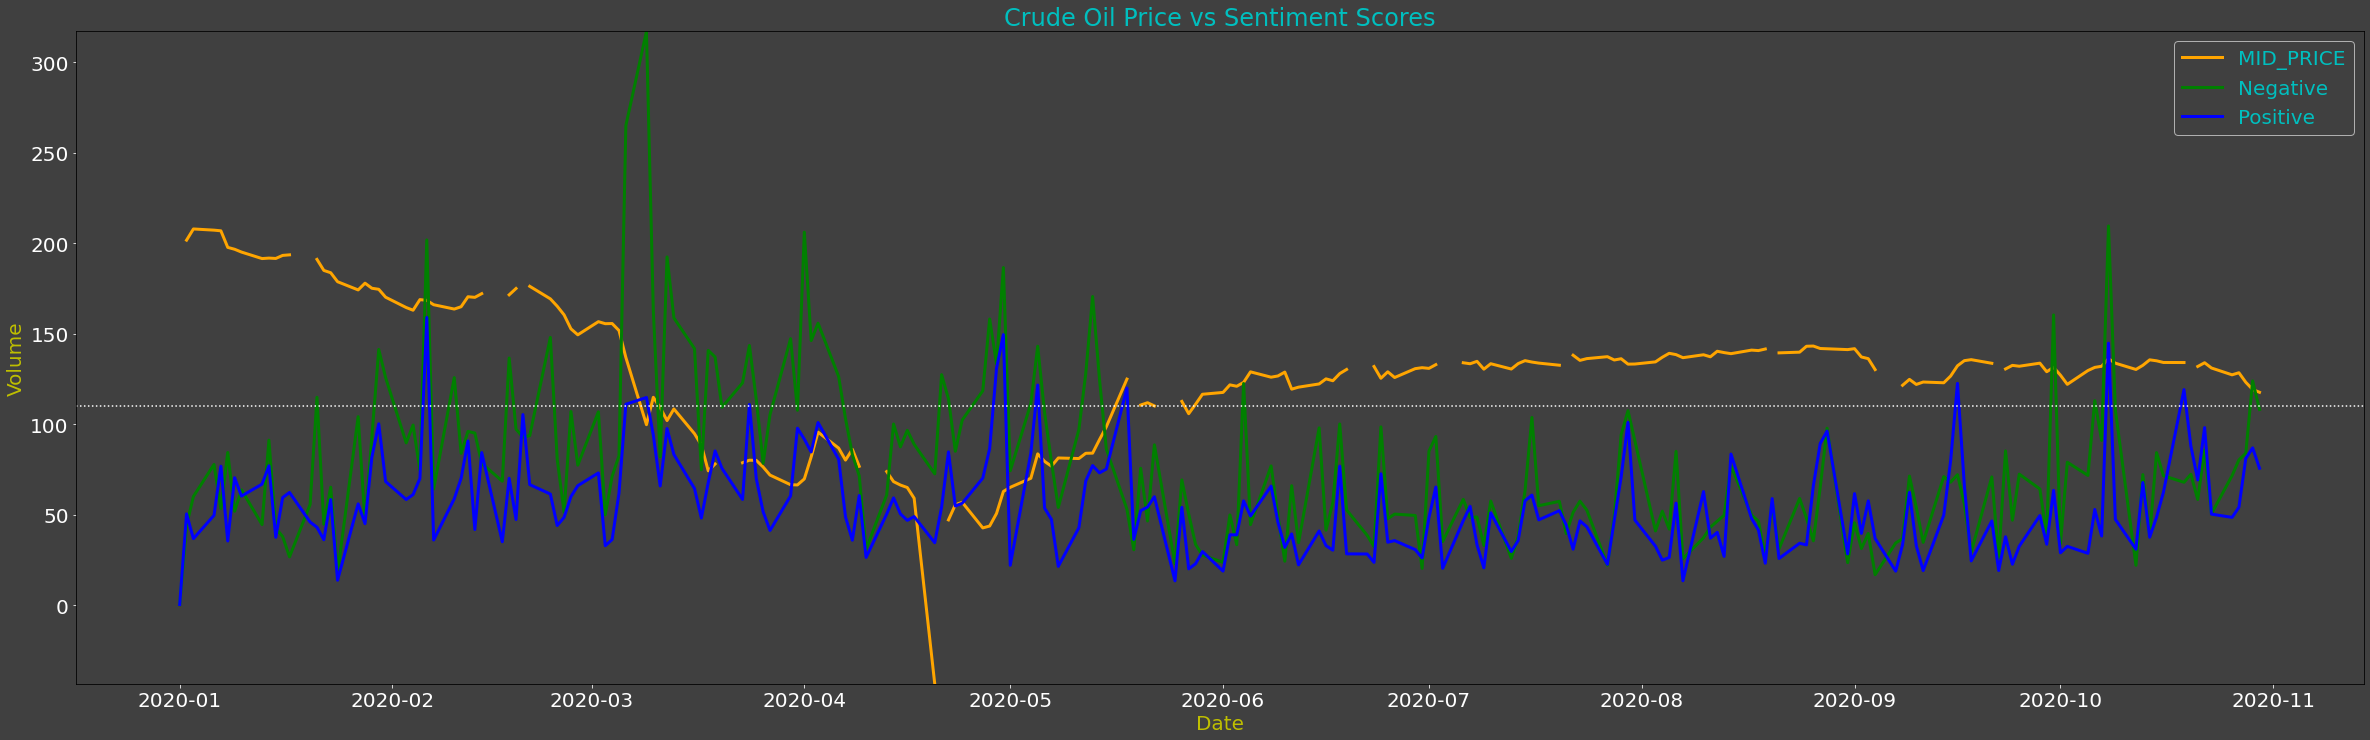

In [17]:
df_mid_vs_sents = plot_compare(df_mid_price, df_sentiments, 'Crude Oil Price vs Sentiment Scores')

Between February and early May, we can see a consistently higher volume of Negative sentiment stories and this is reflected in a downward price movement  
As May progresses, the volume of Positive stories almost matches the negative - this results in some upward price movement

There are several other instances where short-lived spikes in Positive or Negative stories are not necessarily reflected in an equivalent price movement

However, the overriding factor here appears to be the difference between Positive and Negative scoring stories:
* Where we see similar Positive and Negative scoring stories, the price either stabilises or moves upwards   
* Where the number of Negative scoring stories is much higher, the price generally drops

Based on the limited data above - we could also explore the idea that Positive spikes seem to have more of an impact on price than Negative spikes e.g. May and late September.

We could also introduce the **Relevance** score into the mix to help filter out noise - something which I will leave for you to perhaps delve into.

#### Summary
So, does sustained news coverage over an extended period have a greater impact an assets price compared to short lived spikes in volume of news stories? 

Our very basic exploration would suggest that there is certainly merit to this idea.   
Furthermore, we also saw that the difference in sentiment score type also appears to affect the direction of any Price movement.   

We can no doubt refine the basic ideas above further - including using the Relevance value of the stories to filter out noise.